### Prep

Import stuff and define the feature generators and extractor
Code from https://github.com/yedidh/radonomaly

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.covariance import LedoitWolf
from sklearn.metrics import roc_auc_score
import pandas as pd


class TimeSeriesFeatureExtractor():
    def __init__(self, n_channels, n_timesteps, window_size=9):
        self.window_size = window_size
        self.n_resolutions = min(n_timesteps // window_size, 10)

    def extract(self, X):
        Xs = []
        for r in range(1, self.n_resolutions + 1):
            p = (r * self.window_size - r)//2
            print(X.shape, torch.Tensor(X).unsqueeze(3).shape)
            window = F.unfold(torch.Tensor(X).unsqueeze(3),
                              (self.window_size, 1),
                              dilation=(r, 1),
                              padding=(p, 0))
            print(p, window.shape)
            Xs.append(window)
        Xs = torch.cat(Xs, 1)
        #print(Xs.shape)
        return Xs

class CumulativeRadonFeatures(torch.nn.Module):
    def __init__(self, n_channels, n_projections=100, n_quantiles=20):
        self.n_channels = n_channels
        self.n_projections = n_projections
        self.n_quantiles = n_quantiles
        self.projections = torch.randn(self.n_projections,  self.n_channels, 1)

    def fit(self, X):
        a = F.conv1d(X, self.projections).permute((0, 2, 1)).reshape((-1, self.n_projections))
        self.min_vals = torch.quantile(a, 0.01, dim=0)
        self.max_vals = torch.quantile(a, 0.99, dim=0)

    def forward(self, X):
        a = F.conv1d(X, self.projections)
        cdf = torch.zeros((a.shape[0], a.shape[1], self.n_quantiles))
        for q in range(self.n_quantiles):
            threshold = self.min_vals + (self.max_vals - self.min_vals) * (q + 1) / (self.n_quantiles + 1)
            cdf[:, :, q] = (a < threshold.unsqueeze(0).unsqueeze(2)).float().mean(2)
        return cdf.reshape((X.shape[0], -1)).numpy()

class ZCA_Sphering():
    def __init__(self):
        pass

    def fit(self, X):
        cov = LedoitWolf().fit(X).covariance_
        print('cov', cov.shape)
        u, s, vh = np.linalg.svd(cov, hermitian=True, full_matrices=True)
        print('SVD', u.shape, s.shape, vh.shape)
        self.W = np.matmul(np.diag(1/np.sqrt(s)), vh)
        self.mu = X.mean(0)[None, :]

    def transform(self, X):
        X_sph = np.matmul(X - self.mu, self.W.T)
        return X_sph

def anomaly_score(train, test, test_labels):
    # Extract basic feature from the time-series

    ts_extractor = TimeSeriesFeatureExtractor(train.shape[1], train.shape[2], 9)
    train_feats = ts_extractor.extract(train)
    test_feats = ts_extractor.extract(test)
    # Extract Cumulative-Radon features from the input set
    radon_extractor = CumulativeRadonFeatures(train_feats.shape[1])
    radon_extractor.fit(train_feats)
    train_radon = radon_extractor.forward(train_feats)
    test_radon = radon_extractor.forward(test_feats)
    # Sphere the Radon features
    print('Radon features', train_radon.shape)
    zca_sphere = ZCA_Sphering()
    zca_sphere.fit(train_radon)
    test_sph = zca_sphere.transform(test_radon)
    # Simple distance to center anomaly detection
    #auc = roc_auc_score(test_labels, np.power(test_sph, 2).sum(1))
    return ts_extractor, radon_extractor, zca_sphere, test_sph


### Get raw data

and drop a lot since it's 1.8 GB

In [3]:
df_raw = pd.read_csv('./data/normalhoststraining.csv.gz')

In [41]:
# start on a single cluster
dftrain = df_raw[df_raw['clusters'] == 10].drop(columns=['clusters'])

In [35]:
dftrain.columns

Index(['hostname', 'timestamp', 'cpu_busy_pct', 'files_open', 'ip_in_pkts',
       'ip_out_pkts', 'mem_active_kb', 'mem_total_kb', 'mem_used_pct',
       'procs_running'],
      dtype='object')

In [42]:
dftrain.describe()

,timestamp,cpu_busy_pct,files_open,ip_in_pkts,ip_out_pkts,mem_active_kb,mem_total_kb,mem_used_pct,procs_running
count,1.001381e+07,1.001381e+07,1.001381e+07,1.001381e+07,1.001381e+07,1.001381e+07,1.001381e+07,1.001381e+07,1.001381e+07
mean,1.541505e+15,3.596946e-01,3.450220e-03,6.752989e-03,7.402051e-03,9.949028e-02,1.064246e-01,3.803509e-01,1.847880e-03
std,2.743587e+11,2.477391e-01,2.035417e-03,3.775996e-02,4.328168e-02,3.651216e-02,3.582768e-02,1.908265e-01,5.157553e-03
min,1.541030e+15,1.090780e-03,2.999954e-04,8.182722e-07,1.242920e-06,1.815680e-03,5.349285e-02,7.430320e-03,0.000000e+00
25%,1.541267e+15,1.735414e-01,2.238427e-03,8.406163e-04,9.577213e-04,7.209504e-02,7.132366e-02,2.168522e-01,0.000000e+00
50%,1.541505e+15,3.051296e-01,2.976877e-03,1.550138e-03,1.675862e-03,9.944023e-02,7.274363e-02,3.718905e-01,0.000000e+00
75%,1.541743e+15,4.981678e-01,4.015323e-03,2.918922e-03,2.959685e-03,1.253942e-01,1.425514e-01,5.271686e-01,0.000000e+00
max,1.541981e+15,1.000000e+00,3.475331e-02,1.000000e+00,1.000000e+00,2.289310e-01,1.440906e-01,1.000000e+00,6.442308e-01


In [22]:
# cursory glance at one of the hosts
dfh = dftrain[dftrain['hostname'] == 'gsrd153n00.red.ygrid.yahoo.com']
dfh2 = dftrain[dftrain['hostname'] == 'gsrd153n14.red.ygrid.yahoo.com']

<AxesSubplot:xlabel='timestamp'>

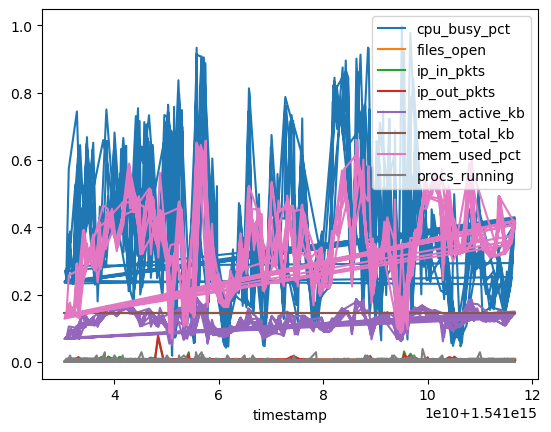

In [24]:
dfh.drop(columns='hostname').set_index('timestamp')[0:1000].plot()

<AxesSubplot:xlabel='timestamp'>

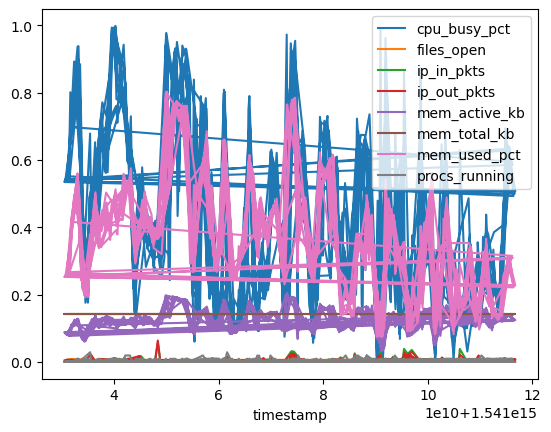

In [25]:
dfh2.drop(columns='hostname').set_index('timestamp')[0:1000].plot()

### Turn data into 3-d Tensor

We tacitly assume data is roughly evenly spaced

In [11]:
# shape the training tensor
#   we only use the first 1000 events to avoid triggering the Linux OOM
MaxLen = 1000
D1 = np.unique(dftrain['hostname']).shape[0]
D2 = dfh.columns.size - 2   # apart from hostname and timestamp
D3 = min(dfh['timestamp'].shape[0], MaxLen)
D3

1000

In [13]:
# allocate 3-d tensor with
# dimension 1 as time series instance counter
# dimension 2 for features/attributes
# dimension 3 for time
dataset = np.zeros((D1, D2, D3),dtype='float')

In [15]:
i=0
for hostname in np.unique(dftrain['hostname']):
    df_host = dftrain[dftrain['hostname'] == hostname].set_index('timestamp').drop(
        columns=['hostname'])
    arra = df_host[['cpu_busy_pct', 'files_open', 'ip_in_pkts',
       'ip_out_pkts', 'mem_active_kb', 'mem_total_kb', 'mem_used_pct',
       'procs_running']][0:MaxLen].to_numpy().T
    if arra.shape[1] < MaxLen: 
        print('', hostname, ' has not enough data ', i, arra.shape[1])
    else: 
        dataset[i] = df_host[['cpu_busy_pct', 'files_open', 'ip_in_pkts',
           'ip_out_pkts', 'mem_active_kb', 'mem_total_kb', 'mem_used_pct',
           'procs_running']][0:MaxLen].to_numpy().T
    i += 1

In [16]:
# don't have to do it again
np.save( './data/DS.numpy', dataset)

In [17]:
# are we satisfied ?
dataset[633]

array([[0.99102269, 0.66376395, 0.66464208, ..., 0.84365219, 0.93751789,
        0.70911257],
       [0.00782296, 0.0044307 , 0.00459224, ..., 0.00692297, 0.0077768 ,
        0.00493839],
       [0.01189214, 0.00888463, 0.00358933, ..., 0.00111198, 0.00195944,
        0.0034197 ],
       ...,
       [0.07132236, 0.07132236, 0.07132236, ..., 0.07132236, 0.07132236,
        0.07132236],
       [0.79309891, 0.54106594, 0.29669318, ..., 0.51373341, 0.60386352,
        0.36947382],
       [0.        , 0.        , 0.02884615, ..., 0.02884615, 0.04807692,
        0.00961538]])

### Train feature generators and extractors

In [18]:
# run the anomaly scorer in training mode
#  return feature generator (tse), radon projector (rde) and ZCA 'adjustor' (zce)
tse, rde, zce, score = anomaly_score(dataset, dataset, np.zeros(634))

(634, 8, 1000) torch.Size([634, 8, 1000, 1])
4 torch.Size([634, 72, 1000])
(634, 8, 1000) torch.Size([634, 8, 1000, 1])
8 torch.Size([634, 72, 1000])
(634, 8, 1000) torch.Size([634, 8, 1000, 1])
12 torch.Size([634, 72, 1000])
(634, 8, 1000) torch.Size([634, 8, 1000, 1])
16 torch.Size([634, 72, 1000])
(634, 8, 1000) torch.Size([634, 8, 1000, 1])
20 torch.Size([634, 72, 1000])
(634, 8, 1000) torch.Size([634, 8, 1000, 1])
24 torch.Size([634, 72, 1000])
(634, 8, 1000) torch.Size([634, 8, 1000, 1])
28 torch.Size([634, 72, 1000])
(634, 8, 1000) torch.Size([634, 8, 1000, 1])
32 torch.Size([634, 72, 1000])
(634, 8, 1000) torch.Size([634, 8, 1000, 1])
36 torch.Size([634, 72, 1000])
(634, 8, 1000) torch.Size([634, 8, 1000, 1])
40 torch.Size([634, 72, 1000])
(634, 8, 1000) torch.Size([634, 8, 1000, 1])
4 torch.Size([634, 72, 1000])
(634, 8, 1000) torch.Size([634, 8, 1000, 1])
8 torch.Size([634, 72, 1000])
(634, 8, 1000) torch.Size([634, 8, 1000, 1])
12 torch.Size([634, 72, 1000])
(634, 8, 1000) t

In [26]:
# compute the score how training data compares against the
#   average ECDF after projection (it will be roughly ~757)
np.linalg.norm(np.power(score,2))

757.6881

### Same for test data

In [27]:
df_rawt = pd.read_csv('./data/anomhoststraining.csv.gz')

In [44]:
# start on a single cluster
dftest = df_rawt[df_rawt['clusters'] == 2].drop(columns=['clusters'])

In [45]:
dftest

,hostname,timestamp,cpu_busy_pct,files_open,ip_in_pkts,ip_out_pkts,mem_active_kb,mem_total_kb,mem_used_pct,procs_running
2050609,gsrd239n08.red.ygrid.yahoo.com,1541030844000000,0.019390,0.001177,0.000014,0.000024,0.076903,0.142523,0.219699,0.009615
2050610,gsrd239n08.red.ygrid.yahoo.com,1541031504000000,0.003253,0.001108,0.000016,0.000026,0.076879,0.142523,0.219653,0.000000
2050611,gsrd239n08.red.ygrid.yahoo.com,1541031924000000,0.002314,0.001131,0.000013,0.000022,0.076916,0.142523,0.219873,0.000000
2050612,gsrd239n08.red.ygrid.yahoo.com,1541033244000000,0.004330,0.000992,0.000015,0.000024,0.076971,0.142523,0.220391,0.000000
2050613,gsrd239n08.red.ygrid.yahoo.com,1541035044000000,0.007528,0.001085,0.000016,0.000027,0.077005,0.142523,0.220985,0.000000
...,...,...,...,...,...,...,...,...,...,...
7875510,gsrd570n18.red.ygrid.yahoo.com,1541104142000000,0.170002,0.001869,0.000005,0.000011,0.061615,0.071754,0.408171,0.000000
7875511,gsrd570n18.red.ygrid.yahoo.com,1541386442000000,0.170570,0.001777,0.000007,0.000014,0.059070,0.071754,0.421598,0.009615
7875512,gsrd570n18.red.ygrid.yahoo.com,1541416142000000,0.172996,0.001777,0.000008,0.000015,0.058268,0.071754,0.417296,0.000000
7875513,gsrd570n18.red.ygrid.yahoo.com,1541429882000000,0.169100,0.001685,0.000003,0.000009,0.058285,0.071754,0.415404,0.009615


In [33]:
np.unique(df_rawt['clusters'])

array([ 2,  3,  5,  6,  8, 14])

In [47]:
dftest['hostname']

2050609    gsrd239n08.red.ygrid.yahoo.com
2050610    gsrd239n08.red.ygrid.yahoo.com
2050611    gsrd239n08.red.ygrid.yahoo.com
2050612    gsrd239n08.red.ygrid.yahoo.com
2050613    gsrd239n08.red.ygrid.yahoo.com
                        ...              
7875510    gsrd570n18.red.ygrid.yahoo.com
7875511    gsrd570n18.red.ygrid.yahoo.com
7875512    gsrd570n18.red.ygrid.yahoo.com
7875513    gsrd570n18.red.ygrid.yahoo.com
7875514    gsrd570n18.red.ygrid.yahoo.com
Name: hostname, Length: 3215524, dtype: object

In [48]:
dfht = dftest[dftest['hostname'] == 'gsrd239n08.red.ygrid.yahoo.com']

In [49]:
# shape the training tensor
#   we only use the first 1000 events to avoid triggering the Linux OOM
MaxLen = 1000
D1t = np.unique(dftest['hostname']).shape[0]
D2t = dfht.columns.size - 2   # apart from hostname and timestamp
D3t = min(dfht['timestamp'].shape[0], MaxLen)
D3t

1000

In [50]:
# allocate 3-d tensor with
# dimension 1 as time series instance counter
# dimension 2 for features/attributes
# dimension 3 for time
datasett = np.zeros((D1t, D2t, D3t),dtype='float')

In [51]:
i=0
for hostname in np.unique(dftest['hostname']):
    df_host = dftest[dftest['hostname'] == hostname].set_index('timestamp').drop(
        columns=['hostname'])
    arra = df_host[['cpu_busy_pct', 'files_open', 'ip_in_pkts',
       'ip_out_pkts', 'mem_active_kb', 'mem_total_kb', 'mem_used_pct',
       'procs_running']][0:MaxLen].to_numpy().T
    if arra.shape[1] < MaxLen: 
        print('', hostname, ' has not enough data ', i, arra.shape[1])
    else: 
        datasett[i] = df_host[['cpu_busy_pct', 'files_open', 'ip_in_pkts',
           'ip_out_pkts', 'mem_active_kb', 'mem_total_kb', 'mem_used_pct',
           'procs_running']][0:MaxLen].to_numpy().T
    i += 1

In [52]:
# don't have to do it again
np.save( './data/DS_test.numpy', datasett)

In [54]:
# are we satisfied ?
datasett[63]

array([[4.88589375e-03, 3.92631377e-03, 7.87349958e-03, ...,
        4.11400115e-03, 1.79407382e-02, 3.34250860e-03],
       [1.13075183e-03, 1.01536899e-03, 1.15382840e-03, ...,
        1.13075183e-03, 1.15382840e-03, 1.10767527e-03],
       [1.96052768e-05, 6.51608905e-05, 1.05000178e-05, ...,
        1.69646119e-05, 3.48108162e-05, 1.09857392e-05],
       ...,
       [7.13223637e-02, 7.13223637e-02, 7.13223637e-02, ...,
        7.13223637e-02, 7.13223637e-02, 7.13223637e-02],
       [2.28638832e-01, 2.29707935e-01, 2.29608982e-01, ...,
        2.36220489e-01, 2.35461507e-01, 2.35432943e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [55]:
# I'm lazy I could have used the existing feature generators and extractors
tse, rde, zce, score = anomaly_score(dataset, datasett, np.zeros(634))

(634, 8, 1000) torch.Size([634, 8, 1000, 1])
4 torch.Size([634, 72, 1000])
(634, 8, 1000) torch.Size([634, 8, 1000, 1])
8 torch.Size([634, 72, 1000])
(634, 8, 1000) torch.Size([634, 8, 1000, 1])
12 torch.Size([634, 72, 1000])
(634, 8, 1000) torch.Size([634, 8, 1000, 1])
16 torch.Size([634, 72, 1000])
(634, 8, 1000) torch.Size([634, 8, 1000, 1])
20 torch.Size([634, 72, 1000])
(634, 8, 1000) torch.Size([634, 8, 1000, 1])
24 torch.Size([634, 72, 1000])
(634, 8, 1000) torch.Size([634, 8, 1000, 1])
28 torch.Size([634, 72, 1000])
(634, 8, 1000) torch.Size([634, 8, 1000, 1])
32 torch.Size([634, 72, 1000])
(634, 8, 1000) torch.Size([634, 8, 1000, 1])
36 torch.Size([634, 72, 1000])
(634, 8, 1000) torch.Size([634, 8, 1000, 1])
40 torch.Size([634, 72, 1000])
(203, 8, 1000) torch.Size([203, 8, 1000, 1])
4 torch.Size([203, 72, 1000])
(203, 8, 1000) torch.Size([203, 8, 1000, 1])
8 torch.Size([203, 72, 1000])
(203, 8, 1000) torch.Size([203, 8, 1000, 1])
12 torch.Size([203, 72, 1000])
(203, 8, 1000) t

In [56]:
score

array([[ 2.4164379 ,  2.5215325 ,  3.6896315 , ..., -9.674957  ,
        -2.0123005 , -0.09947142],
       [ 2.5404532 ,  3.7791662 ,  3.3623304 , ...,  4.0885515 ,
        -1.4451724 , -0.53990716],
       [ 2.4477625 ,  2.7794213 ,  3.5362117 , ..., -5.8283815 ,
         0.44087172, -1.0079057 ],
       ...,
       [ 2.314801  ,  1.4129117 ,  4.347964  , ..., -0.97322154,
        -3.2651045 , -2.156272  ],
       [ 2.120796  ,  0.4072176 ,  4.648118  , ...,  1.4621911 ,
        -4.136779  ,  8.511483  ],
       [ 1.5922486 , -1.4393814 ,  2.8671088 , ...,  0.24817896,
        -0.0643627 , -1.3682926 ]], dtype=float32)

### Big difference to training data ..

In [57]:
# compute the score how training data compares against the
#   average ECDF after projection (it will be roughly ~757 for training)
np.linalg.norm(np.power(score,2))

98947.66

### Concluding remarks

I'd be more at ease if I had anomaly data from the same cluster. Maybe I'm comparing apples and pears here ..